## Numerical implementation

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.sparse import csr_matrix as smatrix
import scipy.sparse.linalg as splinalg
import h5py
import scipy.io as sio
from sklearn.cluster import KMeans
import os
import sys
sources = os.path.join(os.pardir, "modules")
if sources not in sys.path:
    sys.path.insert(0, sources)
import fem

### Application parameters

In [2]:
# Units m->pixel=m/pix2m
# Pa=kg/m/s^2->kg/pixel/s^2=Pa*pix2m
# N = kg.m/s^2->kg.pixel/s^2=N/pix2m
# N/m = kg/s^2->kg/s^2=N/m
stdu=0.5 # noise level displacement in pixel
stdf=.0# N noise level on force
pix2m=25.e-6; # pixel to m conversion
thickness=3e-3 # specimen thicness in m


### DDI parameters

In [3]:
inp='../data/dic-coarse.res'# input file
(X,conn)=fem.readDICmesh(inp)# loading the mesh
model=fem.FEModel() # instantiating a model
model.X=X # Nodes
model.conn=conn # Connectivity
Nnodes=X.shape[0]
Nelems=conn.shape[0]

model.Assemble() # Assembly
W=model.W # Weighting matrix
B=model.B # B matrix for computing strain from displacement

npz=np.load('../data/fem-from-dic.npz')
U=npz['U'] # Input displacement from FE simulation
Fres=(npz['Fres']+stdf)/thickness # Input force from FE simulation
Sref=npz['Sref']*pix2m # Stress field from the FE simulation used as imput data
E_e=B.dot(U) # Input strain
Eref=E_e # considered as the reference
dE_e=B.dot(stdu*np.random.randn(U.size))# noise
E_e=Eref+dE_e # strain to be considered as imput for DDI

# Setting the algorithmic stiffness
L=max(X[:,1])-min(X[:,1])
dL=np.max(U[Nnodes::])-np.min(U[Nnodes::])
section=max(X[:,0])-min(X[:,0])
Co=(Fres/section)/(dL/L)*pix2m


### Boundary conditions
The internal force vector is $0$ everywhere except:
>- on the bottom where the distribution of its $x$ component is unknown
>- on the bottom where the distribution of its $y$ component is unknown
>- on the top where the distribution of its $x$ component is unknown
>- on the top where the sum of the distribution of its $y$ component equals the measured load


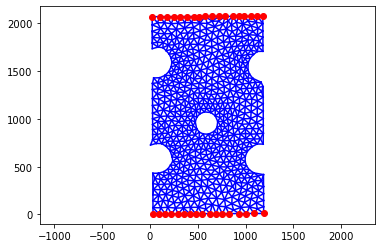

In [4]:

top=X[:,1]>max(X[:,1])*0.99
bot=X[:,1]<max(X[:,1])*0.01

nodes_index=np.arange(Nnodes)
top_nodes=nodes_index[top]
ntop=top_nodes.size
free=np.logical_not(np.logical_or(top, bot))
free_nodes=nodes_index[free]
nfree=free_nodes.size
Free_x=smatrix((np.ones(nfree),(np.arange(nfree),free_nodes)),shape=(2*nfree+1,2*Nnodes))
Free_y=smatrix((np.ones(nfree),(np.arange(nfree)+nfree,free_nodes+Nnodes)),shape=(2*nfree+1,2*Nnodes))
Const_y=smatrix((np.ones(ntop),(2*nfree*np.ones(ntop),top_nodes+Nnodes)),shape=(2*nfree+1,2*Nnodes))


plt.plot(X[conn,0].T,X[conn,1].T,'b-');
plt.plot(X[top,0],X[top,1].T,'ro');
plt.plot(X[bot,0],X[bot,1].T,'ro');


plt.axis('equal');


In [5]:
# Operator assembly
D=B.T*W
Dc=(Free_x+Free_y+Const_y)*(B.T*W)
Fext=np.zeros(2*nfree+1)
Fext[-1]=Fres

iW=scipy.sparse.spdiags(1/W.diagonal(),0,Nelems,Nelems)
C=Dc*(iW*Dc.T)
LU=splinalg.splu(C)

/home/jrethore/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


### Resolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


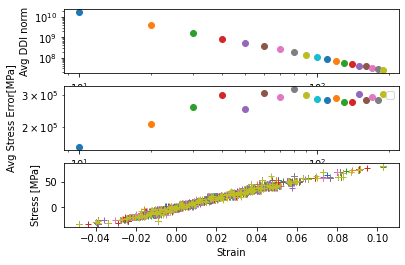

In [6]:
    
# Initialisation
E_e=B.dot(U)
E_e=Eref+dE_e
ff=plt.figure()
plt.subplot(311)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Avg DDI norm')
plt.xlabel('Number of material points')
plt.subplot(312)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Avg Stress Error[MPa]')
plt.xlabel('Noise level [pixel]')
plt.subplot(313)
plt.ylabel('Stress [MPa]')
plt.xlabel('Strain')
ic=0
for Ns in np.arange(10,200,10):
    S_e=np.zeros(Nelems)
    for resampling in range(10):
        ## selection matrix from k-means
        samples=np.c_[np.squeeze(E_e*np.sqrt(Co)),np.squeeze(S_e/np.sqrt(Co))]
        kmeans = KMeans(Ns).fit(samples)
        #.reshape(-1,1))
        ie=kmeans.labels_
        val=np.ones(Nelems)
        ii=np.arange(Nelems)
        S=smatrix((val,(ii,ie)),shape=(Nelems,Ns))
    
    
        ## Material states
        Estar=splinalg.spsolve(S.T*S,S.T.dot(E_e))
        Sstar=splinalg.spsolve(S.T*S,S.T.dot(S_e))


        for iter in range(1):
            Estar_e=S.dot(Estar)
            Sstar_e=S.dot(Sstar)
            b=Dc.dot(Sstar_e)-Fext
            Lag=LU.solve(b)
            S_e=Sstar_e-iW*(Dc.T.dot(Lag))
            Sstar=splinalg.spsolve(S.T*S,S.T.dot(S_e))
    ddi_norm=0.5*(Co*np.dot(E_e-Estar_e,W.dot(E_e-Estar_e))+1/Co*np.dot(S_e-Sstar_e,W.dot(S_e-Sstar_e)))
    Sref=2e8*(1-np.exp(-np.abs(Estar)/0.2))*np.sign(Estar)*pix2m
    ddi_norm_ref=np.linalg.norm(Sref-Sstar)/pix2m
    plt.subplot(311)
    plt.plot(Ns,ddi_norm,'o')
    plt.subplot(312)
    plt.plot(Ns,ddi_norm_ref/Ns,'o')
    plt.subplot(313)
    plt.plot(Estar,Sstar/pix2m*1.e-6,'+',label='Ns=%d' % (Ns));

plt.subplot(312)
plt.legend()

    




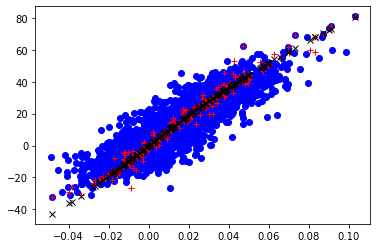

In [7]:
ff=plt.figure()
plt.plot(E_e,S_e/pix2m*1.e-6,'bo');
plt.plot(Estar,Sstar/pix2m*1.e-6,'r+');
plt.plot(Estar,Sref/pix2m*1.e-6,'kx');
